<a href="https://colab.research.google.com/github/gnbhub/gnbai2020w/blob/main/week2/2%EC%A3%BC%EC%B0%A8_%EC%A1%B0%EC%98%81%EC%A7%84.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

###GNB AI Study 2주차
California housing: Regression

###Imports


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import seaborn as sns
from scipy.stats import norm, probplot, skew
from IPython.display import display

from sklearn.preprocessing import StandardScaler

###Load Data

In [2]:
train_df = pd.read_csv('/content/sample_data/california_housing_test.csv')
test_df = pd.read_csv('/content/sample_data/california_housing_train.csv')

In [3]:
train_df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
0,-122.05,37.37,27.0,3885.0,661.0,1537.0,606.0,6.6085,344700.0
1,-118.30,34.26,43.0,1510.0,310.0,809.0,277.0,3.5990,176500.0
2,-117.81,33.78,27.0,3589.0,507.0,1484.0,495.0,5.7934,270500.0
3,-118.36,33.82,28.0,67.0,15.0,49.0,11.0,6.1359,330000.0
4,-119.67,36.33,19.0,1241.0,244.0,850.0,237.0,2.9375,81700.0


In [4]:
train_df.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,3000.000000,3000.00000,3000.000000,3000.000000,3000.000000,3000.000000,3000.00000,3000.000000,3000.00000
mean,-119.589200,35.63539,28.845333,2599.578667,529.950667,1402.798667,489.91200,3.807272,205846.27500
std,1.994936,2.12967,12.555396,2155.593332,415.654368,1030.543012,365.42271,1.854512,113119.68747
min,-124.180000,32.56000,1.000000,6.000000,2.000000,5.000000,2.00000,0.499900,22500.00000
25%,-121.810000,33.93000,18.000000,1401.000000,291.000000,780.000000,273.00000,2.544000,121200.00000
50%,-118.485000,34.27000,29.000000,2106.000000,437.000000,1155.000000,409.50000,3.487150,177650.00000
75%,-118.020000,37.69000,37.000000,3129.000000,636.000000,1742.750000,597.25000,4.656475,263975.00000
max,-114.490000,41.92000,52.000000,30450.000000,5419.000000,11935.000000,4930.00000,15.000100,500001.00000


##Distribution of training data

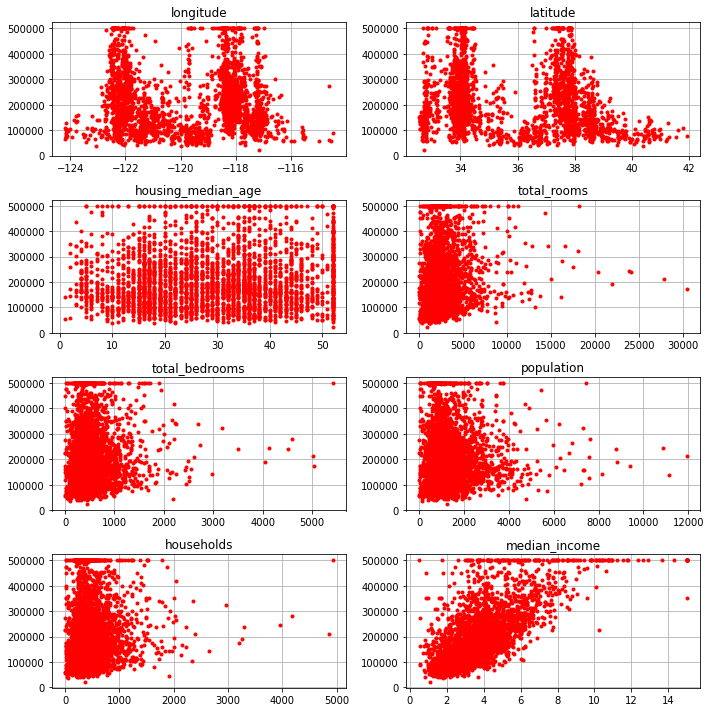

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value


In [5]:
train_df.columns.values.tolist()

def plot_df(df):
  features = df.columns.values.tolist()
  target = features.pop()

  plt.figure(figsize=(10,10))
  for i,feature in enumerate(features):
        plt.subplot(4, 2, i+1)
        plt.grid()
        plt.plot(df[feature], df[target], 'r.')
        plt.title(feature)
  plt.tight_layout()
  plt.show()
  plt.close()

plot_df(train_df)

train_df['population']>=20000

train_df[train_df['population']>=20000]


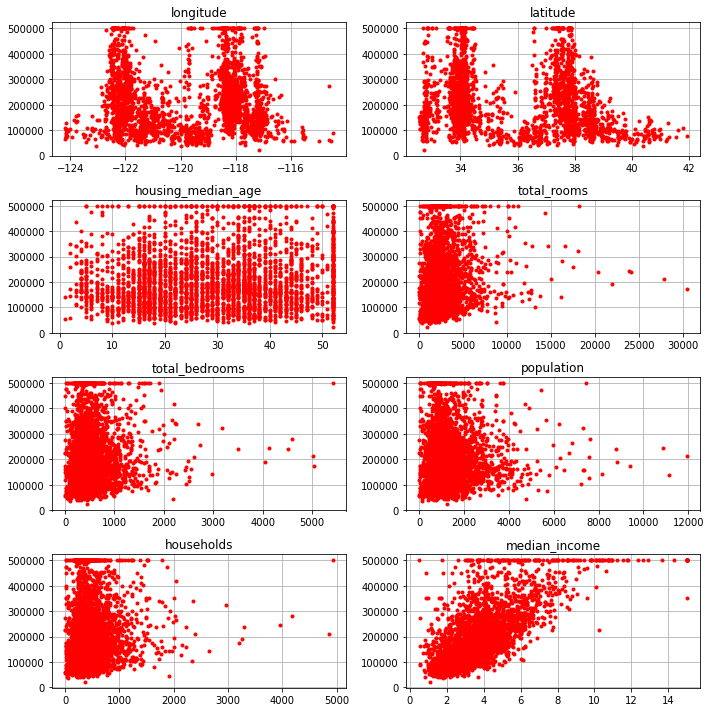

In [6]:
#training outliers(이상값)
train_df = train_df.drop(train_df[train_df['population']>=20000].index)

plot_df(train_df)


###Target variable an analysis


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


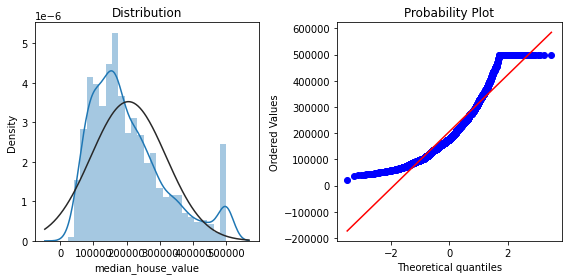

In [7]:
def plot_hist_prob(df, feature):
  plt.figure(figsize=(8,4))
  plt.subplot(1,2,1)

  #plot histogram
  sns.distplot(df[feature], fit=norm)
  plt.title('Distribution')

  plt.subplot(1, 2, 2)
  probplot(df[feature],plot=plt)

  plt.tight_layout()
  plt.show()
  plt.close()    
  
target='median_house_value' 
plot_hist_prob(train_df,target) 

In [8]:
# log-transformation
# log(1+x)-->log1p

train_df[target]=np.log1p(train_df[target])

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


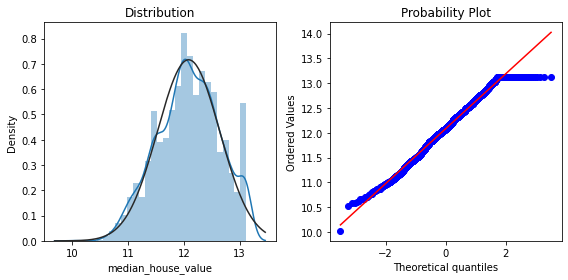

In [9]:
plot_hist_prob(train_df, target)

##Feature engineering 

In [20]:
full_df = pd.concat([
    train_df.drop(target, axis=1),
    test_df.drop(target, axis=1)
])
full_df


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
0,-122.05,37.37,27.0,3885.0,661.0,1537.0,606.0,6.6085
1,-118.30,34.26,43.0,1510.0,310.0,809.0,277.0,3.5990
2,-117.81,33.78,27.0,3589.0,507.0,1484.0,495.0,5.7934
3,-118.36,33.82,28.0,67.0,15.0,49.0,11.0,6.1359
4,-119.67,36.33,19.0,1241.0,244.0,850.0,237.0,2.9375
...,...,...,...,...,...,...,...,...
16995,-124.26,40.58,52.0,2217.0,394.0,907.0,369.0,2.3571
16996,-124.27,40.69,36.0,2349.0,528.0,1194.0,465.0,2.5179
16997,-124.30,41.84,17.0,2677.0,531.0,1244.0,456.0,3.0313
16998,-124.30,41.80,19.0,2672.0,552.0,1298.0,478.0,1.9797


In [22]:
# skewness

def print_skewness():
  feats = full_df.columns.values.tolist()
  skewed_feats = full_df[feats].apply(lambda x: skew(x)).sort_values(ascending=False)
  display(skewed_feats)

print_skewness()  

population            4.944294
total_rooms           4.026108
total_bedrooms        3.400384
households            3.372855
median_income         1.637061
latitude              0.469936
housing_median_age    0.057933
longitude            -0.302986
dtype: float64

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


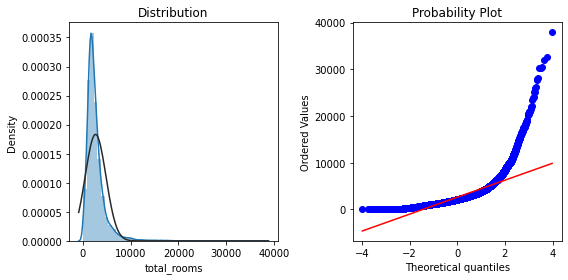

In [24]:
plot_hist_prob(full_df, 'total_rooms')

In [26]:
#boxcox transforation

def fixing_skewness():
  from scipy.special import boxcox1p
  from scipy.stats import boxcox_normmax

  feats = full_df.colums.values.tolist()
  skewed_feats = full_df[feats].apply(lambda x: skew(x)).sort_values(ascending=False)

  high_skew = skewed_feats[skewed_feats > 1]

  for feat in high_skew.index:
    full_df[feat] = boxcox1p(full_df[feat], boxcox_normmax(full_df[feat]+1))



In [27]:
full_df

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
0,-122.05,37.37,27.0,3885.0,661.0,1537.0,606.0,6.6085
1,-118.30,34.26,43.0,1510.0,310.0,809.0,277.0,3.5990
2,-117.81,33.78,27.0,3589.0,507.0,1484.0,495.0,5.7934
3,-118.36,33.82,28.0,67.0,15.0,49.0,11.0,6.1359
4,-119.67,36.33,19.0,1241.0,244.0,850.0,237.0,2.9375
...,...,...,...,...,...,...,...,...
16995,-124.26,40.58,52.0,2217.0,394.0,907.0,369.0,2.3571
16996,-124.27,40.69,36.0,2349.0,528.0,1194.0,465.0,2.5179
16997,-124.30,41.84,17.0,2677.0,531.0,1244.0,456.0,3.0313
16998,-124.30,41.80,19.0,2672.0,552.0,1298.0,478.0,1.9797


In [28]:
scaler = StandardScaler()
full_df.loc[:] = scaler.fit_transform(full_df)

full_df

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
0,-1.239708,0.816095,-0.129372,0.573437,0.292445,0.098533,0.278934,1.439960
1,0.631962,-0.639838,1.142294,-0.517885,-0.542037,-0.545134,-0.582955,-0.143730
2,0.876526,-0.864548,-0.129372,0.437424,-0.073681,0.051672,-0.011855,1.011029
3,0.602015,-0.845822,-0.049893,-1.180949,-1.243381,-1.217094,-1.279801,1.191263
4,-0.051822,0.329224,-0.765205,-0.641491,-0.698948,-0.508884,-0.687744,-0.491832
...,...,...,...,...,...,...,...,...
16995,-2.342745,2.318842,1.857607,-0.193015,-0.342332,-0.458487,-0.341940,-0.797256
16996,-2.347736,2.370338,0.585940,-0.132361,-0.023755,-0.204733,-0.090447,-0.712638
16997,-2.362710,2.908706,-0.924164,0.018356,-0.016623,-0.160526,-0.114025,-0.442471
16998,-2.362710,2.889980,-0.765205,0.016059,0.033304,-0.112781,-0.056391,-0.995855


In [29]:
x_train = full_df[:len(train_df)]
x_test = full_df[len(train_df):]

train_df = pd.concat([x_train, train_df[target]], axis=1)
test_df = pd.concat([x_test, test_df[target]], axis=1)

del x_train, x_test

## AutoML with Pycaret

In [32]:
!pip install pycaret

In [34]:
from pycaret.utils import enable_colab
from pycaret.regression import *

In [35]:
enable_colab()

Colab mode enabled.


In [36]:
train_df

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
0,-1.239708,0.816095,-0.129372,0.573437,0.292445,0.098533,0.278934,1.439960,12.750433
1,0.631962,-0.639838,1.142294,-0.517885,-0.542037,-0.545134,-0.582955,-0.143730,12.081082
2,0.876526,-0.864548,-0.129372,0.437424,-0.073681,0.051672,-0.011855,1.011029,12.508031
3,0.602015,-0.845822,-0.049893,-1.180949,-1.243381,-1.217094,-1.279801,1.191263,12.706851
4,-0.051822,0.329224,-0.765205,-0.641491,-0.698948,-0.508884,-0.687744,-0.491832,11.310822
...,...,...,...,...,...,...,...,...,...
2995,-0.146653,-0.564934,-0.447289,-0.545455,0.247273,-0.148147,0.281553,-1.417208,12.323860
2996,0.711819,-0.733467,-0.129372,1.203876,1.293347,1.830597,1.405414,-0.253397,12.376663
2997,-0.066795,0.315179,-1.480518,-0.772450,-0.801178,-0.647696,-0.732279,-0.832829,11.034906
2998,1.220914,-0.714741,0.903857,-1.167623,-1.245759,-1.219746,-1.271941,-0.316439,11.998439


In [ ]:
reg = setup(data=train_df , target='median_house_value')

IntProgress(value=0, description='Processing: ', max=3)

,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,12:29:40
Status,. . . . . . . . . . . . . . . . . .,Preprocessing Data


Text(value="Following data types have been inferred automatically, if they are correct press enter to continue…

,Data Type
longitude,Numeric
latitude,Numeric
housing_median_age,Numeric
total_rooms,Numeric
total_bedrooms,Numeric
population,Numeric
households,Numeric
median_income,Numeric
median_house_value,Label


In [ ]:
best_3 = compare_models(n_select=3)

In [ ]:
blended = blend_models(estlmator_list=best_3, fold=3)

In [ ]:
pred = predict_model(blended)

In [ ]:
final_model = finalize_model(blended)

In [ ]:
predictions = predict_model(final_mobel, data=test_df)

In [ ]:
predictions.head()

In [ ]:
check_metric(predictions['median_house_value'], np.expm1(prediction['Label']),'R2')

In [ ]:
plot_model(final_model)